# Burgers equation with residual-based adaptive refinement


## Problem setup


We will solve a Burgers equation:

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2u}{\partial x^2}, \qquad x \in [-1, 1], \quad t \in [0, 1]
$$


with the Dirichlet boundary conditions and initial conditions

$$
u(-1,t)=u(1,t)=0, \quad u(x,0) = - \sin(\pi x).
$$

## Dimensional Analysis

### Step 1: Assign Dimensions to Variables

1. **Spatial Coordinate $x$:**
   - The dimension of $x$ is length:

     $$
     [x] = L.
     $$

2. **Time $t$:**
   - The dimension of time is:

     $$
     [t] = T.
     $$

3. **Velocity $u$:**
   - Velocity has dimensions of length per unit time:

     $$
     [u] = L / T.
     $$

4. **Viscosity $\nu$:**
   - The term $\nu \frac{\partial^2 u}{\partial x^2}$ involves the second spatial derivative of velocity, which must have the same dimensions as the time derivative $\frac{\partial u}{\partial t}$.

---

### Step 2: Analyze the Dimensions of Each Term

1. **Time Derivative Term:**
   - The time derivative $\frac{\partial u}{\partial t}$ has dimensions:

     $$
     \left[\frac{\partial u}{\partial t}\right] = \frac{[u]}{[t]} = \frac{L / T}{T} = \frac{L}{T^2}.
     $$

2. **Advection Term:**
   - The advection term $u \frac{\partial u}{\partial x}$ involves the spatial derivative of velocity:

     $$
     \left[u \frac{\partial u}{\partial x}\right] = [u] \cdot \frac{[u]}{[x]} = \frac{L}{T} \cdot \frac{L / T}{L} = \frac{L}{T^2}.
     $$

3. **Diffusion Term:**
   - The diffusion term $\nu \frac{\partial^2 u}{\partial x^2}$ involves the second spatial derivative of velocity:

     $$
     \left[\frac{\partial^2 u}{\partial x^2}\right] = \frac{[u]}{[x]^2} = \frac{L / T}{L^2} = \frac{1}{L T}.
    
     $$
   - Therefore, the diffusion term has dimensions:

     $$
     \left[\nu \frac{\partial^2 u}{\partial x^2}\right] = [\nu] \cdot \frac{1}{L T} = \frac{L}{T^2}.
     $$

---

### Step 3: Determine the Dimensions of $\nu$

- The diffusion term $\nu \frac{\partial^2 u}{\partial x^2}$ must have the same dimensions as the time derivative $\frac{\partial u}{\partial t}$:

  $$
  [\nu] \cdot \frac{1}{L T} = \frac{L}{T^2} \implies [\nu] = \frac{L^2}{T}.
  $$
- Therefore, the viscosity $\nu$ has dimensions of kinematic viscosity:

  $$
  [\nu] = \frac{L^2}{T}.
  $$

---

### Step 4: Summary of Dimensions

| Variable/Parameter     | Physical Meaning                   | Dimensions            |
|------------------------|-----------------------------------|-----------------------|
| $x$                   | Spatial coordinate                | $L$                 |
| $t$                   | Time                              | $T$                 |
| $u$                   | Velocity                          | $L / T$             |
| $\nu$                 | Kinematic viscosity               | $L^2 / T$           |

---

### Step 5: Initial and Boundary Conditions

1. **Boundary Conditions:**
   - The boundary conditions $u(-1,t) = u(1,t) = 0$ are given in meters per second:

     $$
     [u(-1,t)] = [u(1,t)] = L / T.
     $$

2. **Initial Condition:**
   - The initial condition $u(x,0) = -\sin(\pi x)$ is given in meters per second:
   
     $$
     [u(x,0)] = L / T.
     $$
   - The term $\sin(\pi x)$ is dimensionless because $x$ is in meters, and $\pi$ is a dimensionless constant.

## Implementation

This description goes through the implementation of a solver for the above described Burgers equation step-by-step.

First, import the libraries we need:

In [19]:
import brainstate as bst
import brainunit as u
import numpy as np
import jax
import deepxde.experimental as deepxde

We begin by defining a computational geometry and time domain. We can use a built-in class ``Interval`` and ``TimeDomain`` and we combine both the domains using ``GeometryXTime`` as follows:


In [10]:
geomtime = deepxde.geometry.GeometryXTime(
    geometry=deepxde.geometry.Interval(-1., 1.),
    timedomain=deepxde.geometry.TimeDomain(0., 0.99)
).to_dict_point(x=u.meter, t=u.second)

Next, we express the PDE residual of the Burgers equation:

In [11]:
v = 0.01 / u.math.pi * u.meter ** 2 / u.second


def pde(x, y):
    jacobian = approximator.jacobian(x)
    hessian = approximator.hessian(x)
    dy_x = jacobian['y']['x']
    dy_t = jacobian['y']['t']
    dy_xx = hessian['y']['x']['x']
    residual = dy_t + y['y'] * dy_x - v * dy_xx
    return residual

Next, we consider the boundary/initial condition. ``on_boundary`` is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. We include the ``geomtime`` space, time geometry created above and ``on_boundary`` as the BCs in the ``DirichletBC`` function of DeepXDE. We also define ``IC`` which is the inital condition for the burgers equation and we use the computational domain, initial function, and ``on_initial`` to specify the IC.


In [12]:
uy = u.meter / u.second

bc = deepxde.icbc.DirichletBC(lambda x: {'y': 0. * uy})
ic = deepxde.icbc.IC(lambda x: {'y': -u.math.sin(u.math.pi * x['x'] / u.meter) * uy})


Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:


In [13]:
approximator = deepxde.nn.Model(
    deepxde.nn.DictToArray(x=u.meter, t=u.second),
    deepxde.nn.FNN(
        [geometry.dim] + [20] * 3 + [1],
        "tanh",
        bst.init.KaimingUniform()
    ),
    deepxde.nn.ArrayToDict(y=uy)
)

Now, we have specified the geometry, PDE residual, and boundary/initial condition. We then define the ``TimePDE`` problem as


In [14]:
problem = deepxde.problem.TimePDE(
    geometry,
    pde,
    [bc, ic],
    approximator,
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. We also include 160 initial residual points for the initial conditions.

Now, we have the PDE problem and the network. We build a ``Trainer`` and choose the optimizer and learning rate:


In [15]:
trainer = deepxde.Trainer(problem)
trainer.compile(bst.optim.Adam(1e-3)).train(iterations=15000)

Compiling trainer...
'compile' took 0.003058 s

Training trainer...

Step      Train loss                                                       Test loss                                                        Test metric 
0         [2.1140547 * 10.0^0 * ((meter / second) / second) ** 2,          [2.1140547 * 10.0^0 * ((meter / second) / second) ** 2,          []          
           {'ibc0': {'y': 0.09046214 * meter / second}},                    {'ibc0': {'y': 0.09046214 * meter / second}},                               
           {'ibc1': {'y': 0.23645507 * meter / second}}]                    {'ibc1': {'y': 0.23645507 * meter / second}}]                               
1000      [0.05101593 * 10.0^0 * ((meter / second) / second) ** 2,         [0.05101593 * 10.0^0 * ((meter / second) / second) ** 2,         []          
           {'ibc0': {'y': 0.00244636 * meter / second}},                    {'ibc0': {'y': 0.00244636 * meter / second}},                               
           {'

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:


In [16]:
trainer.compile(bst.optim.LBFGS(1e-3)).train(2000, display_every=200)

Compiling trainer...
'compile' took 0.023359 s

Training trainer...

Step      Train loss                                                        Test loss                                                         Test metric 
15000     [0.00067973 * 10.0^0 * ((meter / second) / second) ** 2,          [0.00067973 * 10.0^0 * ((meter / second) / second) ** 2,          []          
           {'ibc0': {'y': 4.3045325e-06 * meter / second}},                  {'ibc0': {'y': 4.3045325e-06 * meter / second}},                             
           {'ibc1': {'y': 0.00046943 * meter / second}}]                     {'ibc1': {'y': 0.00046943 * meter / second}}]                                
15200     [0.00068126 * 10.0^0 * ((meter / second) / second) ** 2,          [0.00068126 * 10.0^0 * ((meter / second) / second) ** 2,          []          
           {'ibc0': {'y': 4.169301e-06 * meter / second}},                   {'ibc0': {'y': 4.169301e-06 * meter / second}},                              
 

Because we only use 2500 residual points for training, the accuracy is low. Next, we improve the accuracy by the residual-based adaptive refinement (RAR) method. Because the Burgers equation has a sharp front, intuitively, we should put more points near the sharp front. First, we randomly generate 100000 points from our domain to calculate the PDE residual.

In [17]:
X = geomtime.random_points(100000)
err = 1

We will repeatedly add points while the mean residual is greater than 0.005. Each iteration, we use our model to generate predictions for inputs in `X` and compute the absolute values of the errors. We then print the mean residual. Next, we find the points where the residual is greatest and add these new points for training PDE loss. Furthermore, we define a callback function to check whether the network converges. If there is significant improvement in the model’s accuracy, as judged by the callback function, we continue to train the model. As before, after we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [20]:
while u.get_magnitude(err) > 0.012:
    f = trainer.predict(X, operator=pde)
    err_eq = u.math.absolute(f)
    err = u.math.mean(err_eq)
    print(f"Mean residual: {err:.3f}")

    x_id = u.math.argmax(err_eq)
    new_xs = jax.tree.map(lambda x: x[[x_id]], X)
    print("Adding new point:", new_xs, "\n")
    problem.add_anchors(new_xs)
    early_stopping = deepxde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    trainer.compile(bst.optim.Adam(1e-3)).train(iterations=10000,
                                                disregard_previous_best=True,
                                                callbacks=[early_stopping])
    trainer.compile(bst.optim.LBFGS(1e-3)).train(1000, display_every=100)

Mean residual: 0.018 * (meter / second) / second
Adding new point: {'t': ArrayImpl([0.31030682], dtype=float32) * second, 'x': ArrayImpl([0.00072277], dtype=float32) * meter} 

Compiling trainer...
'compile' took 0.013387 s

Training trainer...

Step      Train loss                                                        Test loss                                                         Test metric 
17000     [0.00295319 * 10.0^0 * ((meter / second) / second) ** 2,          [0.00067788 * 10.0^0 * ((meter / second) / second) ** 2,          []          
           {'ibc0': {'y': 3.8210997e-06 * meter / second}},                  {'ibc0': {'y': 3.8210997e-06 * meter / second}},                             
           {'ibc1': {'y': 0.00046992 * meter / second}}]                     {'ibc1': {'y': 0.00046992 * meter / second}}]                                
18000     [0.00108327 * 10.0^0 * ((meter / second) / second) ** 2,          [0.0009432 * 10.0^0 * ((meter / second) / second) ** 2,   

Let's visualize and save the data.

Saving loss history to /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/loss.dat ...
Saving checkpoint into /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/loss.dat
Saving training data to /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/train.dat ...
Saving checkpoint into /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/train.dat
Saving test data to /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/test.dat ...
Saving checkpoint into /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/test.dat


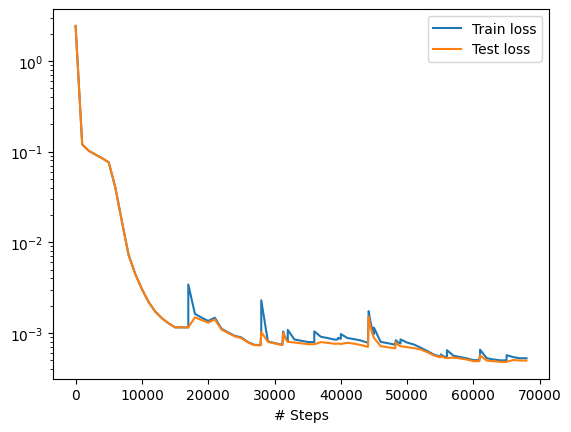

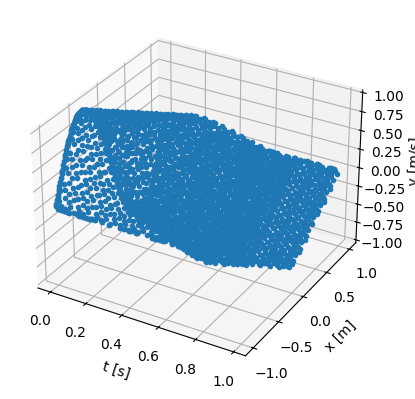

In [21]:
trainer.saveplot(issave=True, isplot=True)

We can also test the model with the data:

In [22]:
def gen_testdata():
    data = np.load("../dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = {'x': np.ravel(xx) * u.meter, 't': np.ravel(tt) * u.second}
    y = exact.flatten()[:, None]
    return X, y * uy

In [23]:
X, y_true = gen_testdata()
y_pred = trainer.predict(X)
f = pde(X, y_pred)
print("Mean residual:", u.math.mean(u.math.absolute(f)))
print("L2 relative error:", deepxde.metrics.l2_relative_error(y_true, y_pred['y']))

Mean residual: 0.01163746 * (meter / second) / second
L2 relative error: 225.97165
